### Test dynamic rerouting service ###

In [5]:
import requests
import time
import base64
import pandas as pd
from tqdm import tqdm
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def send_request(is_secure):
    start_time = time.time()
    url = base_url
    if is_secure:
        url = base_url + "predict-secure/"
    else:
        url = base_url + "predict-public/"
    response = requests.post(url, json=sample_data)
    response_time = time.time() - start_time
    return response.status_code, response_time

### Send groups of requests separately ###

In [4]:
public_times = []
secure_times = []

base_url = '18.223.114.102'  
num_public_requests = 10
num_secure_requests = 10
batch_size = 2

print('Sending requests...')

for _ in range(num_public_requests):
    status, time_taken = send_request(is_secure=False)
    public_times.append(time_taken)

for _ in range(num_secure_requests):
    status, time_taken = send_request(is_secure=True)
    secure_times.append(time_taken)

avg_public_time = sum(public_times) / len(public_times)
avg_secure_time = sum(secure_times) / len(secure_times)

print(f'Average response time for public requests: {avg_public_time:.4f} seconds.')
print(f'Average response time for secure requests: {avg_secure_time:.4f} seconds.')

Sending requests...


NameError: name 'sample_data' is not defined

### Send intermixed in a single loop ###

In [12]:
def base64_encode(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

sample_image = "sample_images/sample_cat.jpeg"
encoded_image = base64_encode(sample_image)
encoded_images = [encoded_image] * batch_size

sample_data = {"images": encoded_images}

In [8]:
def send_requests(base_url, num_public, num_secure, batch_size):

    num_requests = num_public + num_secure
    public_times = []
    secure_times = []
    
    prob_secure = num_secure / num_requests
    
    print(f'Sending {num_secure} secure requests and {num_public} public requests with batch size {batch_size}')
    
    for _ in tqdm(range(num_requests), desc="Sending requests"):
        is_secure = random.random() < prob_secure  
    
        status, time_taken = send_request(is_secure=is_secure)
        if is_secure:
            secure_times.append(time_taken)
        else:
            public_times.append(time_taken)

    stats = {
        'Request Type': ['Public', 'Secure'],
        'Average Time': [
            sum(public_times) / len(public_times),
            sum(secure_times) / len(secure_times)
        ],
        'Minimum Time': [min(public_times), min(secure_times)],
        'Maximum Time': [max(public_times), max(secure_times)],
        'Proportion Secure': prob_secure
    }

    result_df = pd.DataFrame(stats)
    return result_df

In [15]:
base_url = 'http://18.223.114.102/'  
num_public_requests = 5
num_secure_requests = 5
batch_size = 2

df = send_requests(base_url, num_public_requests, num_secure_requests, batch_size)

Sending 5 secure requests and 5 public requests with batch size 2


Sending requests: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


In [16]:
df

,Request Type,Average Time,Minimum Time,Maximum Time,Proportion Secure
0,Public,0.393436,0.375042,0.409764,0.5
1,Secure,0.674325,0.481555,0.929695,0.5


In [22]:
#splits = [(20, 80), (40, 60), (50, 50), (60, 40), (80, 20)]
splits = [(100, 100)]

results = [] 
for public, secure in splits:
    df = send_requests(base_url, public, secure, batch_size)
    results.append(df)
combined_df = pd.concat(results, ignore_index=True)

combined_df

Sending 100 secure requests and 100 public requests with batch size 2


Sending requests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:40<00:00,  2.00it/s]


,Request Type,Average Time,Minimum Time,Maximum Time,Proportion Secure
0,Public,0.439993,0.363164,0.942216,0.5
1,Secure,0.547611,0.451129,0.959439,0.5


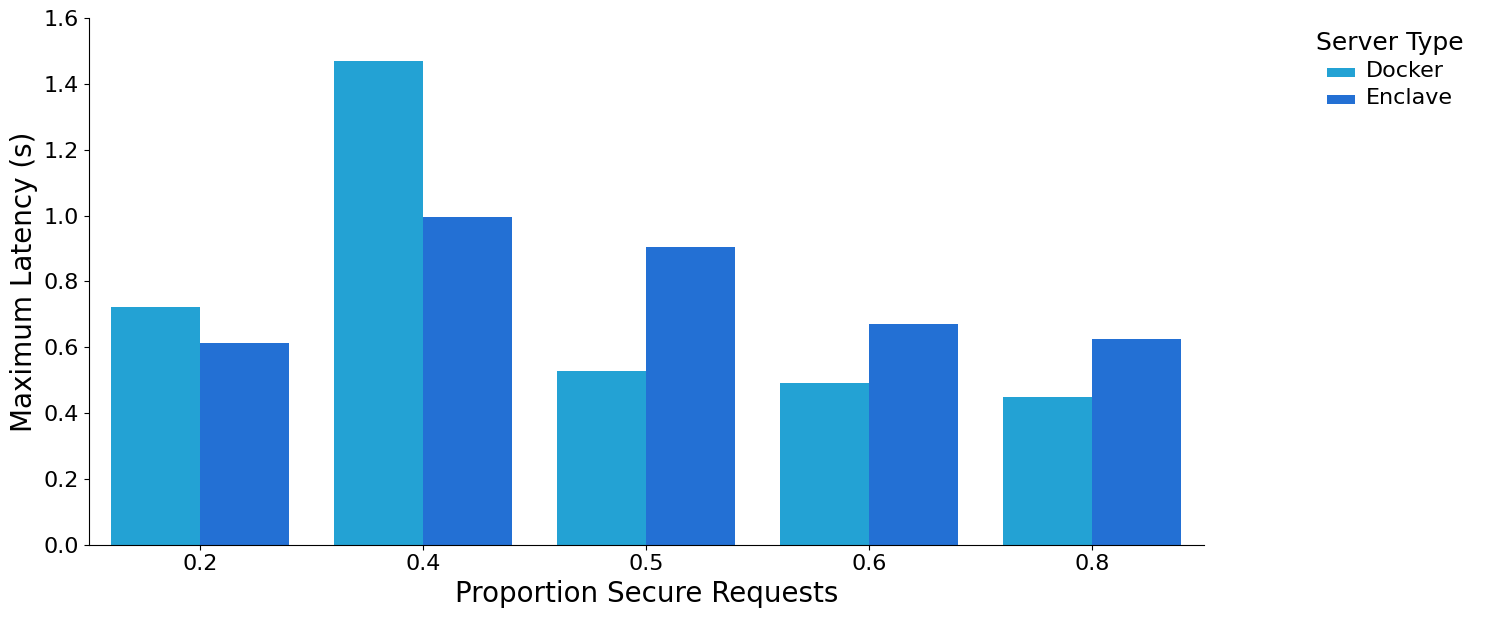

In [43]:
palette = {'Public': '#05aff2', 'Secure': '#056cf2'} 

g = sns.catplot(
    data=combined_df, 
    x='Proportion Secure', 
    y='Maximum Time', 
    hue='Request Type', 
    kind='bar', 
    height=6, 
    aspect=2, 
    palette=palette
)

g.set_axis_labels("Proportion Secure Requests", "Maximum Latency (s)", fontsize=20)
g.set_xticklabels(fontsize=16)
g.set_yticklabels(fontsize=16)

new_labels = ['Docker', 'Enclave'] 
g._legend.set_title('Server Type')
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.setp(g._legend.get_texts(), fontsize=16)  # for legend text
plt.setp(g._legend.get_title(), fontsize=18)  # for legend title
g._legend.set_bbox_to_anchor((1, 1))
g._legend._loc = 2 

# Show plot
plt.show()


In [46]:
combined_df.to_csv("results/routing_test_batch2_no_threads.csv", index=False)